In [192]:
import pandas as pd
import numpy as np
import sys
import os
from datetime import datetime
import statsmodels.api as sm
sys.path.append("/Users/yuchenlin/Project/Tools/Asset-Pricing-Tools")
import basictool
import anomalytest

In [193]:
engine = anomalytest.BacktestEngine(stdate=datetime(1960,1,1),eddate=datetime(2024,12,31))
base_universe = engine.crsp_m_processed.copy()

Initializing BacktestEngine...
Loading raw data files...
Loading factor models...
Processing raw CRSP data...
CRSP data processing complete.
BacktestEngine initialized successfully.


In [194]:
def get_statutory_tax_rate(year):
    """
    返回美国联邦法定最高企业所得税率 (1963-2020)
    数据来源: IRS / Tax Foundation
    """
    if year <= 1963:
        return 0.52
    elif year == 1964:
        return 0.50
    elif 1965 <= year <= 1967:
        return 0.48
    elif 1968 <= year <= 1969:
        return 0.528  # 包含附加税
    elif year == 1970:
        return 0.492
    elif 1971 <= year <= 1978:
        return 0.48
    elif 1979 <= year <= 1986:
        return 0.46
    elif year == 1987:
        return 0.40   # 1986税改过渡
    elif 1988 <= year <= 1992:
        return 0.34
    elif 1993 <= year <= 2017:
        return 0.35
    elif year >= 2018:
        return 0.21
    else:
        return 0.35 # 默认值，防止报错

In [195]:
def _form_portfolios(factorname, formation_data, quantiles, nyse_breakpoints):
        all_constituents = []
        for dt, monthly_slice in formation_data.groupby('date'):
            nyse_data = monthly_slice[monthly_slice['exchcd'] == 1] if nyse_breakpoints else monthly_slice
            
            num_groups = quantiles if isinstance(quantiles, int) else len(quantiles) + 1
            if nyse_data.empty or nyse_data[factorname].nunique() < num_groups:
                print(f"Warning: Skipping date {dt.date()} due to insufficient unique factor values to form {num_groups} groups.")
                continue
            try:
                if isinstance(quantiles, int):
                    breakpoints = nyse_data[factorname].quantile(np.linspace(0, 1, quantiles + 1)[1:-1]).tolist()
                    labels = [f"P{i+1}" for i in range(quantiles)]
                else: # 自定义分位点
                    breakpoints = nyse_data[factorname].quantile(quantiles).tolist()
                    labels = [f"P{i+1}" for i in range(len(quantiles) + 1)]
                full_breakpoints = [-np.inf] + breakpoints + [np.inf]
                monthly_slice['portfolio'] = pd.cut(monthly_slice[factorname], bins=full_breakpoints, labels=labels, right=True, include_lowest=True)
            except (ValueError, IndexError) as e:
                print(f"Warning: Could not form portfolios on {dt.date()}: {e}")
                continue
            
            monthly_slice.dropna(subset=['portfolio'], inplace=True)
            if monthly_slice.empty:
                continue
            
            all_constituents.append(monthly_slice[['date', 'permno', 'portfolio']])
            
        if not all_constituents:
            raise ValueError("Could not form any portfolios.")
        return pd.concat(all_constituents, ignore_index=True)

In [196]:
def _calculate_portfolio_returns(constituents, returns_df, rebal_freq, lag):
        constituents = constituents.copy().rename(columns={'date':'formation_date'})
        # 只需要成分股ID和构建日期
        constituents = constituents[['permno', 'formation_date', 'portfolio']] 
        
        returns_df = returns_df.copy()

        # 定义交易开始时间
        constituents['trade_start_date'] = constituents['formation_date'].apply(lambda d: d + pd.offsets.MonthBegin(lag))
        
        returns_df = returns_df.sort_values('date')
        constituents = constituents.sort_values('trade_start_date')
        
        # Merge Asof
        merged = pd.merge_asof(
            returns_df, 
            constituents, 
            left_on='date', 
            right_on='trade_start_date', 
            by='permno', 
            direction='backward'
        )
        # 确保 returns_df 包含 'me_lag' 用于计算 Value Weight
        if 'me_lag' not in merged.columns:
            raise ValueError("merged must contain 'me_lag' for correct VW calculations.")
        # 计算月份差
        month_diff = (merged['date'].dt.to_period('M').astype(int) - 
                      merged['formation_date'].dt.to_period('M').astype(int))
        
        # 修正的筛选逻辑
        if rebal_freq == 'M':
            # 月度调仓：只保留 month_diff == lag 的数据
            # 例如：1月31构建，lag=1，我们只想要2月28的数据(diff=1)。3月(diff=2)的数据是旧的
            valid_mask = (month_diff == lag)
        else: # 'A'
            # 年度调仓：保留 lag 到 lag + 11
            valid_mask = (month_diff >= lag) & (month_diff < (lag + 12))
            
        merged = merged[valid_mask].copy()
        
        # 剔除无效数据
        merged.dropna(subset=['portfolio', 'ret'], inplace=True)
        
        # 动态计算权重 (每一期重新计算组内权重)
        # Equal Weight
        merged['ew_weight'] = 1.0
        
        # Value Weight (使用 returns_df 当期的 me_lag)
        # 注意：这里的分母是 "当期该组合内所有股票的me_lag之和"，这才是标准的VW
        grouper = merged.groupby(['date', 'portfolio'])
        merged['vw_weight'] = grouper['me_lag'].transform(lambda x: x / x.sum())
        merged['ew_weight'] = grouper['ew_weight'].transform(lambda x: x / x.sum())
        
        merged['ew_ret'] = merged['ret'] * merged['ew_weight']
        merged['vw_ret'] = merged['ret'] * merged['vw_weight']
        
        port_ret = merged.groupby(['date', 'portfolio'])[['ew_ret', 'vw_ret']].sum().unstack()
        port_count = merged.groupby(['date', 'portfolio'])['ret'].count().unstack()
        
        # --- 后续多空组合计算逻辑不变 ---
        long_port_num = len([c for c in port_ret.columns.get_level_values(1).unique() if 'P' in str(c)])
        long_port = f"P{long_port_num}"
        short_port = "P1"
        if ('ew_ret', long_port) in port_ret.columns and ('ew_ret', short_port) in port_ret.columns:
            port_ret[('ew_ret', 'LS')] = port_ret[('ew_ret', long_port)] - port_ret[('ew_ret', short_port)]
            port_ret[('vw_ret', 'LS')] = port_ret[('vw_ret', long_port)] - port_ret[('vw_ret', short_port)]
        return port_ret, port_count

In [197]:
def _get_performance_metrics(returns_series, annual_factor):
    if returns_series.empty or returns_series.isnull().all() or len(returns_series) < 2:
        return [np.nan] * 3
    mean_return = returns_series.mean()
    volatility = returns_series.std()
    if volatility == 0 or pd.isna(volatility): 
        return [mean_return * annual_factor, 0, np.nan]
    t_stat = mean_return / (volatility / np.sqrt(len(returns_series)))
    # TODO: newly-west adjusted

    return [mean_return * annual_factor, volatility * np.sqrt(annual_factor), t_stat]

In [198]:
def _run_factor_model_regression(engine, portfolio_returns, model_name,port):
    rf_rate = engine.factor_models['CAPM'][['rf']]
    merged_data = pd.merge(portfolio_returns.rename('ret'), rf_rate, left_index=True, right_index=True, how='inner')
    if port != 'LS':
        merged_data['excess_ret'] = merged_data['ret'] - merged_data['rf']
    else:
        merged_data['excess_ret'] = merged_data['ret'] 
    if merged_data.shape[0] < 12:
        return np.nan, np.nan
    y = merged_data['excess_ret']
    factors = {'CAPM': ['mkt_rf'], 'FF3': ['mkt_rf', 'smb', 'hml'],'FF5': ['mkt_rf', 'smb', 'hml', 'rmw', 'cma'], 'Q': ['mkt_rf', 'me', 'ia', 'roe'], 'Q5': ['mkt_rf', 'me', 'ia', 'roe', 'eg']}
    X = engine.factor_models[model_name][factors[model_name]]
    X = pd.merge(merged_data, X, left_index=True, right_index=True, how='inner')[factors[model_name]]
    X.dropna()
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    return model.params['const']*12, model.tvalues['const']

In [199]:
BM_group = pd.read_csv('BM_group.csv',parse_dates=['date'])
CI_group = pd.read_csv('CI_group.csv',parse_dates=['date'])

In [200]:
BM_decile = _form_portfolios('BM',BM_group,10,nyse_breakpoints=True)
BM_group = BM_group.merge(BM_decile,on=['permno','date'])
BM_ret_m, BM_count_m = _calculate_portfolio_returns(BM_group, base_universe[['permno', 'date', 'ret','me_lag']], rebal_freq='Y', lag=1)
BM_ret_m['ew_ret'] = BM_ret_m['ew_ret'] * 100
BM_ret_m['vw_ret'] = BM_ret_m['vw_ret'] * 100
BM_ret_m = BM_ret_m[BM_ret_m.index>=datetime(1963,1,1)]
BM_ret_m = BM_ret_m[BM_ret_m.index<=datetime(2005,6,30)]

CI_decile = _form_portfolios('ci',CI_group,10,nyse_breakpoints=True)
CI_group = CI_group.merge(CI_decile,on=['permno','date'])
CI_ret_m, CI_count_m = _calculate_portfolio_returns(CI_group, base_universe[['permno', 'date', 'ret','me_lag']], rebal_freq='Y', lag=1)
CI_ret_m['ew_ret'] = CI_ret_m['ew_ret'] * 100
CI_ret_m['vw_ret'] = CI_ret_m['vw_ret'] * 100
CI_ret_m = CI_ret_m[CI_ret_m.index>=datetime(1963,1,1)]
CI_ret_m = CI_ret_m[CI_ret_m.index<=datetime(2005,6,30)]

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/3769137254.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = merged.groupby(['date', 'portfolio'])
/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/3769137254.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  port_ret = merged.groupby(['date', 'portfolio'])[['ew_ret', 'vw_ret']].sum().unstack()
/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/3769137254.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

In [201]:
summary_results = []
port_list = BM_ret_m.columns.get_level_values(1).unique()
for port in port_list:
    ew_m, ew_vol_m, ew_t_m = _get_performance_metrics(BM_ret_m['ew_ret'][port], 12)
    vw_m, vw_vol_m, vw_t_m = _get_performance_metrics(BM_ret_m['vw_ret'][port], 12)
    res = {'portfolio': port, 'ew_ret_monthly': ew_m, 'ew_vol_monthly': ew_vol_m}
    for model_name in ['CAPM', 'FF3']:
        alpha, t_alpha = _run_factor_model_regression(engine,BM_ret_m['ew_ret'][port], model_name,port)
        res[f'{model_name}_alpha'] = alpha
        res[f'{model_name}_t_alpha'] = t_alpha
    summary_results.append(res)
performance_summary = pd.DataFrame(summary_results).round(1)
PortRet_BM = performance_summary[performance_summary['portfolio'].isin(['P1','P5','P10','LS'])].T

In [202]:
PortRet_BM

,0,4,9,10
portfolio,P1,P5,P10,LS
ew_ret_monthly,10.1,15.8,24.8,14.8
ew_vol_monthly,24.7,20.1,22.4,16.4
CAPM_alpha,-3.3,3.8,13.3,16.6
CAPM_t_alpha,-1.6,2.3,5.4,6.8
FF3_alpha,-0.8,0.1,5.9,6.7
FF3_t_alpha,-0.6,0.1,4.0,4.1


In [203]:
summary_results = []
port_list = CI_ret_m.columns.get_level_values(1).unique()
for port in port_list:
    ew_m, ew_vol_m, ew_t_m = _get_performance_metrics(CI_ret_m['ew_ret'][port], 12)
    vw_m, vw_vol_m, vw_t_m = _get_performance_metrics(CI_ret_m['vw_ret'][port], 12)
    res = {'portfolio': port, 'ew_ret_monthly': ew_m, 'ew_vol_monthly': ew_vol_m}
    for model_name in ['CAPM', 'FF3']:
        alpha, t_alpha = _run_factor_model_regression(engine,CI_ret_m['ew_ret'][port], model_name,port)
        res[f'{model_name}_alpha'] = alpha
        res[f'{model_name}_t_alpha'] = t_alpha
    summary_results.append(res)
performance_summary = pd.DataFrame(summary_results).round(1)
PortRet_CI = performance_summary[performance_summary['portfolio'].isin(['P1','P5','P10','LS'])].T

In [204]:
PortRet_CI

,0,4,9,10
portfolio,P1,P5,P10,LS
ew_ret_monthly,21.1,16.6,14.6,-6.5
ew_vol_monthly,24.1,19.1,21.7,7.6
CAPM_alpha,8.3,4.6,2.2,-6.2
CAPM_t_alpha,3.5,3.3,1.1,-5.3
FF3_alpha,4.5,1.3,-1.4,-5.9
FF3_t_alpha,3.3,1.5,-1.2,-5.2


In [205]:
BM_group

,Unnamed: 0,date,permno,exchcd,ME,BM,year,siccd,fyr,capital,...,tau_t,tau_t1,output_t1,capital_t1,investment_t1,debt_t1,at_t1,dp_t1,r^b,portfolio
0,62,1987-06-30,10005,3,1.011937,4.381035,1987,1310,12,2.404,...,0.400,0.34,0.249,3.421,0.004,0.057,1.376,0.440,0.110050,P10
1,75,1970-06-30,10006,1,217.178500,0.824890,1970,3743,12,468.413,...,0.492,0.48,332.704,508.177,34.698,194.373,497.393,22.865,0.089558,P7
2,76,1971-06-30,10006,1,310.173500,0.939381,1971,3743,12,508.177,...,0.480,0.48,343.679,538.241,28.635,179.539,506.785,23.231,0.083933,P7
3,77,1972-06-30,10006,1,242.769875,0.879396,1972,3743,12,538.241,...,0.480,0.48,436.146,562.548,55.575,211.280,580.766,24.864,0.080558,P7
4,78,1973-06-30,10006,1,255.073000,1.012582,1973,3743,12,562.548,...,0.480,0.48,535.097,611.334,68.245,260.782,675.170,27.930,0.086275,P7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67134,230085,2018-06-30,93436,3,58478.463905,0.080626,2018,9999,12,23168.820,...,0.210,0.21,24578.000,23343.447,1432.000,14697.000,34309.000,2107.000,0.048800,P1
67135,230086,2019-06-30,93436,3,40025.710071,0.085708,2019,9999,12,23343.447,...,0.210,0.21,31536.000,25062.000,3232.000,13347.000,52148.000,2322.000,0.039325,P1
67136,230087,2020-06-30,93436,3,200844.671160,0.087374,2020,9999,12,25062.000,...,0.210,0.21,53823.000,29893.000,6514.000,8873.000,62131.000,2911.000,0.034083,P1
67137,230088,2021-06-30,93436,3,668826.848940,0.033035,2021,9999,12,29893.000,...,0.210,0.21,81462.000,39867.000,7163.000,5748.000,82338.000,3747.000,0.038775,P1


In [206]:
BM_agg = BM_group.groupby(['year','portfolio'])[['capital','investment','output','debt','dec_me','dp_t1','capital_t1','investment_t1','output_t1']].sum().reset_index()
BM_agg['y_k_t1'] = BM_agg['output_t1'] / BM_agg['capital_t1']
BM_agg['i_k_t1'] = BM_agg['investment_t1'] / BM_agg['capital_t1']
BM_agg['i_k_t'] = BM_agg['investment'] / BM_agg['capital']
BM_agg['delta_t1'] =  BM_agg['dp_t1'] / BM_agg['capital_t1']
BM_agg['w_t'] = BM_agg['debt'] / (BM_agg['debt'] + BM_agg['dec_me'])

BM_agg = BM_agg[['year','portfolio','y_k_t1','i_k_t1','i_k_t','delta_t1','w_t']]

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/3858813695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  BM_agg = BM_group.groupby(['year','portfolio'])[['capital','investment','output','debt','dec_me','dp_t1','capital_t1','investment_t1','output_t1']].sum().reset_index()


In [207]:
raw_path = '~/Raw_data/'
FRED_PATH = raw_path + 'FRED/'

baa = pd.read_csv(FRED_PATH + 'Baayield.csv',parse_dates=['observation_date'])
baa['year'] = baa['observation_date'].dt.to_period('Y-Jun').dt.year -1
baa['BAA'] = baa['BAA']/100
baa['r^b'] = baa.groupby('year')['BAA'].transform('mean') +1
baa = baa[['year','r^b']]
baa = baa.drop_duplicates(['year'])

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/291953366.py:5: FutureWarning: 'Y-Jun' is deprecated and will be removed in a future version, please use 'Y-JUN' instead.
  baa['year'] = baa['observation_date'].dt.to_period('Y-Jun').dt.year -1


In [208]:
BM_rI = BM_ret_m['ew_ret'].unstack().reset_index().rename(columns={0:'r_s'})
BM_rI['r_s'] = BM_rI['r_s'] / 100 + 1
BM_rI['year'] = BM_rI['date'].dt.to_period('Y-Jun').dt.year -1
BM_rI['r_s'] = BM_rI.groupby(['year','portfolio'])['r_s'].transform('prod')
BM_rI = BM_rI[['portfolio','year','r_s']]
BM_rI = BM_rI.drop_duplicates(['portfolio','year'])

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/2747855710.py:3: FutureWarning: 'Y-Jun' is deprecated and will be removed in a future version, please use 'Y-JUN' instead.
  BM_rI['year'] = BM_rI['date'].dt.to_period('Y-Jun').dt.year -1


In [209]:
GMM_df = BM_agg.merge(BM_rI,on=['portfolio','year']).merge(baa,on=['year'])
GMM_df['tau_t'] = (GMM_df['year']).apply(get_statutory_tax_rate)
GMM_df['tau_t1'] = (GMM_df['year'] + 1).apply(get_statutory_tax_rate)
GMM_df['r_ba'] = GMM_df['r^b'] - (GMM_df['r^b'] - 1) * GMM_df['tau_t1']

In [210]:
CI_agg = CI_group.groupby(['year','portfolio'])[['capital','investment','output','debt','dec_me','dp_t1','capital_t1','investment_t1','output_t1']].sum().reset_index()
CI_agg['y_k_t1'] = CI_agg['output_t1'] / CI_agg['capital_t1']
CI_agg['i_k_t1'] = CI_agg['investment_t1'] / CI_agg['capital_t1']
CI_agg['i_k_t'] = CI_agg['investment'] / CI_agg['capital']
CI_agg['delta_t1'] =  CI_agg['dp_t1'] / CI_agg['capital_t1']
CI_agg['w_t'] = CI_agg['debt'] / (CI_agg['debt'] + CI_agg['dec_me'])

CI_agg = CI_agg[['year','portfolio','y_k_t1','i_k_t1','i_k_t','delta_t1','w_t']]

CI_rI = CI_ret_m['ew_ret'].unstack().reset_index().rename(columns={0:'r_s'})
CI_rI['r_s'] = CI_rI['r_s'] / 100 + 1
CI_rI['year'] = CI_rI['date'].dt.to_period('Y-Jun').dt.year -1
CI_rI['r_s'] = CI_rI.groupby(['year','portfolio'])['r_s'].transform('prod')
CI_rI = CI_rI[['portfolio','year','r_s']]
CI_rI = CI_rI.drop_duplicates(['portfolio','year'])

GMM_df_CI = CI_agg.merge(CI_rI,on=['portfolio','year']).merge(baa,on=['year'])
GMM_df_CI['tau_t'] = (GMM_df_CI['year']).apply(get_statutory_tax_rate)
GMM_df_CI['tau_t1'] = (GMM_df_CI['year'] + 1).apply(get_statutory_tax_rate)
GMM_df_CI['r_ba'] = GMM_df_CI['r^b'] - (GMM_df_CI['r^b'] - 1) * GMM_df_CI['tau_t1']
GMM_df_CI['rb100'] = (GMM_df_CI['r^b']-1) * 100

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/1849830052.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CI_agg = CI_group.groupby(['year','portfolio'])[['capital','investment','output','debt','dec_me','dp_t1','capital_t1','investment_t1','output_t1']].sum().reset_index()
/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_14170/1849830052.py:12: FutureWarning: 'Y-Jun' is deprecated and will be removed in a future version, please use 'Y-JUN' instead.
  CI_rI['year'] = CI_rI['date'].dt.to_period('Y-Jun').dt.year -1


In [211]:
GMM_df_CI.groupby('portfolio').mean().round(1).T

portfolio,P1,P10,P2,P3,P4,P5,P6,P7,P8,P9
year,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0
y_k_t1,1.9,1.7,1.6,1.6,1.5,1.5,1.5,1.6,1.7,1.7
i_k_t1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
i_k_t,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
delta_t1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
w_t,0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2
r_s,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.1
r^b,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
tau_t,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
tau_t1,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4


In [212]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

class LWZ_GMM:
    def __init__(self, df, portfolios):
        """
        df: 包含所有变量的长表 DataFrame
        portfolios: 投资组合列表 (e.g., ['P1', 'P2', ..., 'P10'])
        """
        self.portfolios = portfolios
        self.T = df['year'].nunique() # 时间长度
        self.N = len(portfolios)      # 资产数量
        
        # 将长表转换为宽表矩阵 (Time x Assets)
        # 方便后续矩阵运算
        self.data = {}
        vars_map = {
            'y_k_t1': 'y_k_t1', 'i_k_t': 'i_k_t', 'i_k_t1': 'i_k_t1',
            'tau_t': 'tau_t', 'tau_t1': 'tau_t1', 
            'delta_t1': 'delta_t1', 'w_t': 'w_t', 
            'r_ba': 'r_ba', 'r_s': 'r_s'
        }
        
        # 自动 Pivot 数据
        for col, key in vars_map.items():
            # 确保你的df列名和这里匹配
            if col not in df.columns:
                print(f"Warning: {col} not found in dataframe")
                continue
            pivot_df = df.pivot(index='year', columns='portfolio', values=col)
            # 确保列顺序一致
            self.data[key] = pivot_df[portfolios].values 

    def calculate_r_Iw(self, a, alpha):
        """
        计算杠杆化投资收益率 r^Iw (核心物理公式)
        对应论文公式 (3) 和 (5)
        """
        d = self.data
        
        # --- Step 1: 计算无杠杆投资收益率 r^I (Eq 3) ---
        # 分子各项
        term1 = (1 - d['tau_t1']) * alpha * d['y_k_t1']
        term2 = (1 - d['tau_t1']) * (a / 2) * (d['i_k_t1'] ** 2)
        term3 = d['tau_t1'] * d['delta_t1']
        term4 = (1 - d['delta_t1']) * (1 + (1 - d['tau_t1']) * a * d['i_k_t1'])
        
        numerator = term1 + term2 + term3 + term4
        
        # 分母
        denominator = 1 + (1 - d['tau_t']) * a * d['i_k_t']
        
        r_I = numerator / denominator
        
        # --- Step 2: 计算杠杆化收益率 r^Iw (Eq 5) ---
        # 注意: w_t 是期初杠杆
        r_Iw = (r_I - d['w_t'] * d['r_ba']) / (1 - d['w_t'])
        
        return r_Iw

    def gmm_objective(self, params):
        """
        GMM 目标函数: g_T' W g_T
        """
        a, alpha = params
        
        # 1. 计算模型隐含收益率
        r_Iw = self.calculate_r_Iw(a, alpha)
        
        # 2. 计算定价误差 (Model Error) e = r^S - r^Iw
        # 这是一个 T x N 的矩阵
        errors = self.data['r_s'] - r_Iw
        
        # 3. 计算样本矩 (Sample Moments) g_T = E[e]
        # 对时间取平均，得到 1 x N 向量
        g_T = np.mean(errors, axis=0)
        
        # 4. 目标函数 (使用单位矩阵 W = I)
        # 论文 Page 1111: "We use the identity weighting matrix"
        J = np.dot(g_T, g_T) # 等价于 g_T' I g_T
        
        return J

    def fit(self, init_params=[5.0, 0.3]):
        """
        执行优化
        """
        # 约束条件: a > 0, alpha > 0 (可选，但推荐)
        bnds = ((0.01, None), (0.01, 0.99))
        
        res = minimize(self.gmm_objective, init_params, bounds=bnds, method='L-BFGS-B')
        
        self.estimated_params = res.x
        self.a_hat, self.alpha_hat = res.x
        
        return res

    def get_statistics(self):
        """
        计算标准误、卡方检验和 MAE (论文 Table 2 的所有内容)
        """
        a, alpha = self.estimated_params
        
        # 1. 重算误差时间序列 (T x N)
        r_Iw = self.calculate_r_Iw(a, alpha)
        errors = self.data['r_s'] - r_Iw # u_t
        g_T = np.mean(errors, axis=0)    # g_T
        
        # 2. 计算 Jacobian 矩阵 d (N x K)
        # d = d g_T / d theta
        # 使用数值微分
        epsilon = 1e-5
        d_matrix = np.zeros((self.N, 2))
        
        # 对 a 求导
        r_Iw_plus = self.calculate_r_Iw(a + epsilon, alpha)
        g_plus = np.mean(self.data['r_s'] - r_Iw_plus, axis=0)
        d_matrix[:, 0] = (g_plus - g_T) / epsilon
        
        # 对 alpha 求导
        r_Iw_plus_alpha = self.calculate_r_Iw(a, alpha + epsilon)
        g_plus_alpha = np.mean(self.data['r_s'] - r_Iw_plus_alpha, axis=0)
        d_matrix[:, 1] = (g_plus_alpha - g_T) / epsilon
        
        # 3. 计算 S 矩阵 (Spectral Density Matrix)
        # 使用 Newey-West (Bartlett kernel) with lag = 5 (论文设置)
        S = np.zeros((self.N, self.N))
        L = 5
        
        # Gamma_0
        S += (errors.T @ errors) / self.T
        
        # Gamma_k
        for k in range(1, L + 1):
            weight = 1 - k / (L + 1)
            # 协方差: E[u_t * u_{t-k}']
            Gamma_k = (errors[k:].T @ errors[:-k]) / self.T
            S += weight * (Gamma_k + Gamma_k.T)
            
        # 4. 计算方差-协方差矩阵 Var(b)
        # 公式: (d'Wd)^-1 d'W S W d (d'Wd)^-1
        # 因为 W = I，简化为: (d'd)^-1 d' S d (d'd)^-1
        # 还要除以 T
        
        inv_dd = np.linalg.inv(d_matrix.T @ d_matrix)
        bread = inv_dd @ d_matrix.T
        var_cov = (bread @ S @ bread.T) / self.T
        
        se = np.sqrt(np.diag(var_cov))
        
        # 5. J-Test (Chi-Square)
        # 论文公式 (B3): g_T' [Var(g_T)]^+ g_T
        # Var(g_T) = (I - d(d'd)^-1 d') S (I - d(d'd)^-1 d')' / T
        
        I = np.eye(self.N)
        M = I - d_matrix @ inv_dd @ d_matrix.T
        var_g = (M @ S @ M.T) / self.T
        
        # 使用广义逆 (Pseudo-inverse) 因为矩阵秩亏
        chi2_stat = g_T.T @ np.linalg.pinv(var_g) @ g_T
        df = self.N - 2 # Moments - Parameters
        from scipy.stats import chi2
        p_val = 1 - chi2.cdf(chi2_stat, df)
        
        # 6. Mean Absolute Error (MAE)
        mae = np.mean(np.abs(g_T)) * 100 # 转为百分比
        
        return {
            'a': a, 'a_se': se[0],
            'alpha': alpha, 'alpha_se': se[1],
            'chi2': chi2_stat, 'df': df, 'p_val': p_val,
            'mae': mae,
            'errors': g_T * 100, # 各组合误差 %
            'pred_ret': np.mean(r_Iw, axis=0) * 100,
            'real_ret': np.mean(self.data['r_s'], axis=0) * 100
        }

    def plot_scatter(self, stats):
        """
        复现 Figure 1: Realized vs Predicted Returns
        """
        plt.figure(figsize=(8, 8))
        
        x = stats['real_ret']
        y = stats['pred_ret']
        labels = self.portfolios
        
        sns.scatterplot(x=x, y=y, s=100, color='black')
        
        # 45度线
        min_val = min(min(x), min(y)) - 20
        max_val = max(max(x), max(y)) + 20
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
        
        # 标注点
        for i, txt in enumerate(labels):
            plt.text(x[i]+0.2, y[i]-0.2, txt, fontsize=9)
        
        plt.xlim(105,130)
        plt.ylim(105,130)
        plt.xlabel('Average Realized Returns (%)', fontsize=12)
        plt.ylabel('Average Predicted Returns (%)', fontsize=12)
        plt.title(f'Realized vs Predicted Returns\nMAE: {stats["mae"]:.2f}%', fontsize=14)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.show()

------------------------------
Table 2 Replication Results
------------------------------
Parameter Estimates:
  a     = 15.98 (11.94)
  alpha = 0.34 (0.11)
------------------------------
Model Performance:
  Chi-square = 5.15
  d.f.       = 8
  p-value    = 0.74
  m.a.e.     = 1.13%
------------------------------
Individual Portfolio Errors (% per year):
  P1: -0.28%
  P2: -1.30%
  P3: -2.57%
  P4: 0.53%
  P5: -0.03%
  P6: 1.72%
  P7: 0.37%
  P8: -1.03%
  P9: 2.74%
  P10: -0.72%


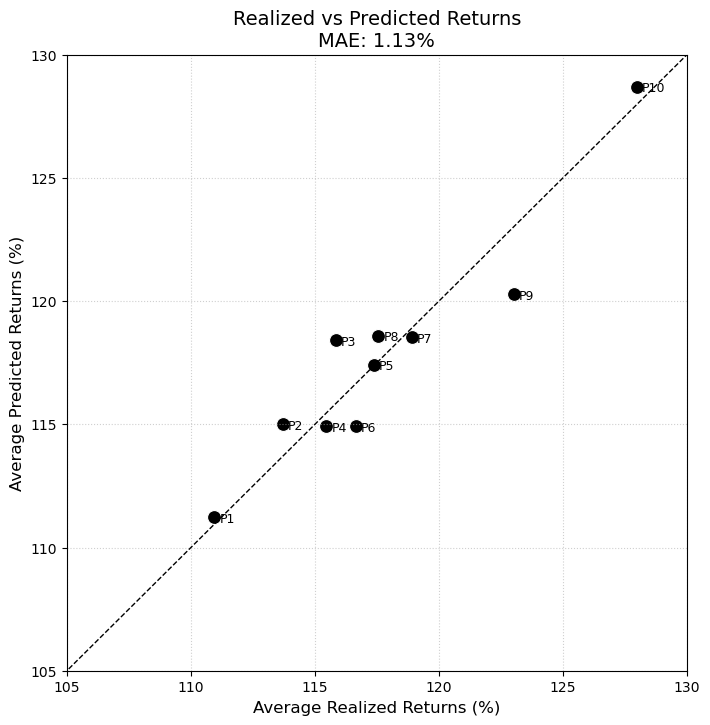

In [219]:
# 1. 定义投资组合列表 (按顺序)
portfolios = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# 2. 初始化 GMM 模型
model = LWZ_GMM(GMM_df, portfolios)

# 3. 运行估计
res = model.fit(init_params=[1, 0.3]) # 初始值 a=1, alpha=0.3

# 4. 获取统计结果
stats = model.get_statistics()

# ==========================================
# 打印 Table 2 风格的报告
# ==========================================
print("-" * 30)
print("Table 2 Replication Results")
print("-" * 30)
print(f"Parameter Estimates:")
print(f"  a     = {stats['a']:.2f} ({stats['a_se']:.2f})")
print(f"  alpha = {stats['alpha']:.2f} ({stats['alpha_se']:.2f})")
print("-" * 30)
print(f"Model Performance:")
print(f"  Chi-square = {stats['chi2']:.2f}")
print(f"  d.f.       = {stats['df']}")
print(f"  p-value    = {stats['p_val']:.2f}")
print(f"  m.a.e.     = {stats['mae']:.2f}%")
print("-" * 30)
print("Individual Portfolio Errors (% per year):")
for p, e in zip(portfolios, stats['errors']):
    print(f"  {p}: {e:.2f}%")

# 5. 画图 Figure 1
model.plot_scatter(stats)

------------------------------
Table 2 Replication Results
------------------------------
Parameter Estimates:
  a     = 1.24 (0.74)
  alpha = 0.20 (0.02)
------------------------------
Model Performance:
  Chi-square = 5.11
  d.f.       = 8
  p-value    = 0.75
  m.a.e.     = 1.37%
------------------------------
Individual Portfolio Errors (% per year):
  P1: -3.34%
  P2: 2.02%
  P3: 0.28%
  P4: 1.91%
  P5: 2.22%
  P6: 0.42%
  P7: 0.87%
  P8: -0.10%
  P9: -0.90%
  P10: -1.62%


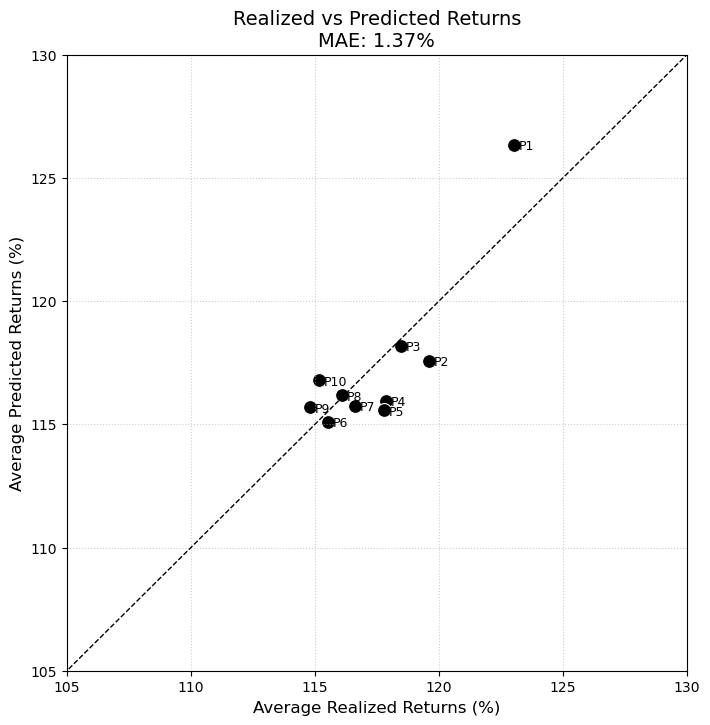

In [214]:
# 1. 定义投资组合列表 (按顺序)
portfolios = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# 2. 初始化 GMM 模型
model = LWZ_GMM(GMM_df_CI, portfolios)

# 3. 运行估计
res = model.fit(init_params=[5, 0.8]) # 初始值 a=1, alpha=0.3

# 4. 获取统计结果
stats = model.get_statistics()

# ==========================================
# 打印 Table 2 风格的报告
# ==========================================
print("-" * 30)
print("Table 2 Replication Results")
print("-" * 30)
print(f"Parameter Estimates:")
print(f"  a     = {stats['a']:.2f} ({stats['a_se']:.2f})")
print(f"  alpha = {stats['alpha']:.2f} ({stats['alpha_se']:.2f})")
print("-" * 30)
print(f"Model Performance:")
print(f"  Chi-square = {stats['chi2']:.2f}")
print(f"  d.f.       = {stats['df']}")
print(f"  p-value    = {stats['p_val']:.2f}")
print(f"  m.a.e.     = {stats['mae']:.2f}%")
print("-" * 30)
print("Individual Portfolio Errors (% per year):")
for p, e in zip(portfolios, stats['errors']):
    print(f"  {p}: {e:.2f}%")

# 5. 画图 Figure 1
model.plot_scatter(stats)